## Objetivo:

O objetivo desta competição é desenvolver um modelo preditor do ELDT (Estimated Landing Time) para voos comerciais com origem e 
destino nos 12 principais aeródromos do Brasil, a saber:

- Brasília (SBBR)
- Confins (SBCF)
- Curitiba (SBCT)
- Florianópolis (SBFL)
- Rio de Janeiro - Galeão (SBGL)
- Guarulhos (SBGR)
- Campinas (SBKP)
- Porto Alegre (SBPA)
- Recife (SBRF)
- Rio de Janeiro - Santos Dumont (SBRJ)
- São Paulo - Congonhas (SBSP)
- Salvador (SBSV)

In [ ]:
!pip install xgboost

import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import xgboost as xg

import requests
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

random.seed(1)

print(f'tf_version: {tf.__version__}')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 2.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
2023-09-14 16:51:48.874376: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 16:51:49.003808: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-14 16:51:49.003844: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-09-14 16:51:49.022775: E tensorflow/stream_executor/cuda/cuda_blas.cc:2

In [ ]:
# Carregar o dataset BIMTRA

"""

A base de dados BIMTRA possui informações dos movimentos nos aeródromos do Brasil. Assim, é possível encontrar 
dados como hora de decolagem estimada, origem, destino, tempo de voo previsto, etc. Para o problema em questão, 
uma versão resumida do BIMTRA será fornecida, contendo os seguintes campos:

FlightID (Identificador único de um voo)
Origem (Código ICAO do Aeroporto de Origem do voo)
Destino (Código ICAO do Aeroporto de Destino do voo)
Hora_Dep (Data/Hora de Decolagem do voo)
Hora_Arr (Data/Hora de Pouso do voo)

O campo Hora_Arr corresponde ao atributo alvo do desafio proposto, isto é, o modelo desenvolvido por cada equipe 
deverá estimar os valores de Hora_Arr. Tomem cuidado com data leakage, ou seja, construindo modelos com informações do futuro.


"""

url = 'http://montreal.icea.decea.mil.br:5002/api/v1/bimtra'
params = {
    'token': 'a779d04f85c4bf6cfa586d30aaec57c44e9b7173',
    'idate': '2023-01-01',
    'fdate': '2023-02-01'
}

headers = {'accept': 'application/json'}

response = requests.get(url, params=params, headers=headers)

if response.status_code == 200:
    BIMTRA_json = response.json()
    print("BIMTRA carregado com sucesso!")
else:
    print(f"A solicitação falhou com status code {response.status_code}")


BIMTRA carregado com sucesso!


In [ ]:
BIMTRA_df = pd.DataFrame(BIMTRA_json)
print(BIMTRA_df)
# Converter "dt_dep" e "dt_arr" para objetos de data e hora
# BIMTRA_df['dt_dep'] = pd.to_datetime(BIMTRA_df['dt_dep'], unit='ms')
# BIMTRA_df['dt_arr'] = pd.to_datetime(BIMTRA_df['dt_arr'], unit='ms')

                               flightid origem destino         dt_dep  \
0      33ce5d33ca3414163a9a53b8ef481306   SBCF    SBKP  1672532479000   
1      af199802cfa3ca88b4ed914d5d6eeac8   SBRJ    SBSP  1672531827000   
2      a3c9ce921ea79926bd098837cabc0cdd   SBKP    SBPA  1672537722000   
3      8d03bca2ee2d1def11cd7e8c5e5aa0ae   SBBR    SBCF  1672536591000   
4      95093c33bb1c2c612ff0b56c65d05dbe   SBKP    SBGL  1672539714000   
...                                 ...    ...     ...            ...   
27384  783af9769d54638a2e50437558879fd0   SBCF    SBGR  1675258279000   
27385  9b392363bc952a42e0e036eaeaaa37ea   SBBR    SBGR  1675260249000   
27386  f9fad7a3ace67914c4e2a5033edb5782   SBCT    SBGR  1675255923000   
27387  8b55f0da1f2bac4a17e5d48bac7c052b   SBCF    SBGR  1675288765000   
27388  3fe770905db2b15565d682007aad9120   SBRF    SBGR  1675256456000   

              dt_arr  
0      1672535819000  
1      1672534699000  
2      1672542680000  
3      1672540037000  
4      1

In [ ]:
display(BIMTRA_df.head())
display(BIMTRA_df.info())

,flightid,origem,destino,dt_dep,dt_arr
0,33ce5d33ca3414163a9a53b8ef481306,SBCF,SBKP,1672532479000,1672535819000
1,af199802cfa3ca88b4ed914d5d6eeac8,SBRJ,SBSP,1672531827000,1672534699000
2,a3c9ce921ea79926bd098837cabc0cdd,SBKP,SBPA,1672537722000,1672542680000
3,8d03bca2ee2d1def11cd7e8c5e5aa0ae,SBBR,SBCF,1672536591000,1672540037000
4,95093c33bb1c2c612ff0b56c65d05dbe,SBKP,SBGL,1672539714000,1672541937000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27389 entries, 0 to 27388
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   flightid  27389 non-null  object
 1   origem    27389 non-null  object
 2   destino   27389 non-null  object
 3   dt_dep    27389 non-null  int64 
 4   dt_arr    27389 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.0+ MB


None

In [ ]:
# Cálculo do ELDT 
# ELDT = (pd.to_datetime(BIMTRA_df.dt_arr) - pd.to_datetime(BIMTRA_df.dt_dep)).dt.total_seconds()
ELDT = BIMTRA_df['dt_arr'] - BIMTRA_df['dt_dep']
BIMTRA_df['eldt'] = ELDT
BIMTRA_df

,flightid,origem,destino,dt_dep,dt_arr,eldt
0,33ce5d33ca3414163a9a53b8ef481306,SBCF,SBKP,1672532479000,1672535819000,3340000
1,af199802cfa3ca88b4ed914d5d6eeac8,SBRJ,SBSP,1672531827000,1672534699000,2872000
2,a3c9ce921ea79926bd098837cabc0cdd,SBKP,SBPA,1672537722000,1672542680000,4958000
3,8d03bca2ee2d1def11cd7e8c5e5aa0ae,SBBR,SBCF,1672536591000,1672540037000,3446000
4,95093c33bb1c2c612ff0b56c65d05dbe,SBKP,SBGL,1672539714000,1672541937000,2223000
...,...,...,...,...,...,...
27384,783af9769d54638a2e50437558879fd0,SBCF,SBGR,1675258279000,1675261109000,2830000
27385,9b392363bc952a42e0e036eaeaaa37ea,SBBR,SBGR,1675260249000,1675264712000,4463000
27386,f9fad7a3ace67914c4e2a5033edb5782,SBCT,SBGR,1675255923000,1675258787000,2864000
27387,8b55f0da1f2bac4a17e5d48bac7c052b,SBCF,SBGR,1675288765000,1675292684000,3919000


# 1. Tratamento de Dados

## 1.1 Células vazias e duplicadas

In [ ]:
# Checagem de células vazias
display(pd.DataFrame(BIMTRA_df.isnull().sum(), columns=['Nº Células Vazias']))

# Checagem de células duplicadas
print('Número de duplicatas: ', BIMTRA_df.duplicated().sum())
BIMTRA_df.drop_duplicates(inplace=False)

,Nº Células Vazias
flightid,0
origem,0
destino,0
dt_dep,0
dt_arr,0
eldt,0


Número de duplicatas:  267


,flightid,origem,destino,dt_dep,dt_arr,eldt
0,33ce5d33ca3414163a9a53b8ef481306,SBCF,SBKP,1672532479000,1672535819000,3340000
1,af199802cfa3ca88b4ed914d5d6eeac8,SBRJ,SBSP,1672531827000,1672534699000,2872000
2,a3c9ce921ea79926bd098837cabc0cdd,SBKP,SBPA,1672537722000,1672542680000,4958000
3,8d03bca2ee2d1def11cd7e8c5e5aa0ae,SBBR,SBCF,1672536591000,1672540037000,3446000
4,95093c33bb1c2c612ff0b56c65d05dbe,SBKP,SBGL,1672539714000,1672541937000,2223000
...,...,...,...,...,...,...
27384,783af9769d54638a2e50437558879fd0,SBCF,SBGR,1675258279000,1675261109000,2830000
27385,9b392363bc952a42e0e036eaeaaa37ea,SBBR,SBGR,1675260249000,1675264712000,4463000
27386,f9fad7a3ace67914c4e2a5033edb5782,SBCT,SBGR,1675255923000,1675258787000,2864000
27387,8b55f0da1f2bac4a17e5d48bac7c052b,SBCF,SBGR,1675288765000,1675292684000,3919000


## 1.2 Valores negativos

In [ ]:
# Máscara booleana das linhas <= 0
mask = BIMTRA_df['eldt'] <= 0

print('Número de linhas onde ELDT <= 0: ', BIMTRA_df[mask].values.shape[0])
display(BIMTRA_df[mask])

# Remove as linhas
BIMTRA_df_adjusted = BIMTRA_df[~mask]

Número de linhas onde ELDT <= 0:  36


,flightid,origem,destino,dt_dep,dt_arr,eldt
2484,e82048177bf7703fd3f22425d9b1084f,SBRJ,SBFL,1672853315000,1672848993000,-4322000
4149,2b348d145754b8e9ac4de0469ed300fe,SBGR,SBFL,1673049307000,1672976477000,-72830000
7232,2d68d999f28e86f6154abc230129299d,SBSP,SBSV,1673266052000,1673262285000,-3767000
7942,da5697c4e136e01d1b236b84eb274c74,SBCF,SBRJ,1673347923000,1673345424000,-2499000
7946,45ebb4cfe8fa0f5f3d8f5526dc29af44,SBSP,SBRJ,1673348700000,1673345133000,-3567000
9938,6fef9d0d16cc5caf436d6b2e0252337b,SBFL,SBCF,1673520735000,1673512805000,-7930000
10575,90c4f6e70efbc6d27e4c91d74fca8e32,SBSP,SBRJ,1673652586000,1673568759000,-83827000
10623,160bb02f015c30491bf93a77c39f48ac,SBRJ,SBCT,1673652708000,1673569914000,-82794000
10794,5e3c31e3163c1b53d07a2e1eedc0f5bd,SBCT,SBRJ,1673651833000,1673569460000,-82373000
10879,5902b8ad90fa4c362f57f43fbfbc0972,SBRJ,SBBR,1673650148000,1673570008000,-80140000


# 2. EDA

Aparentemente nos casos em que o ELDT foi negativo, houve uma inversão entre origem e destino

Text(0.5, 1.0, 'ELDT')

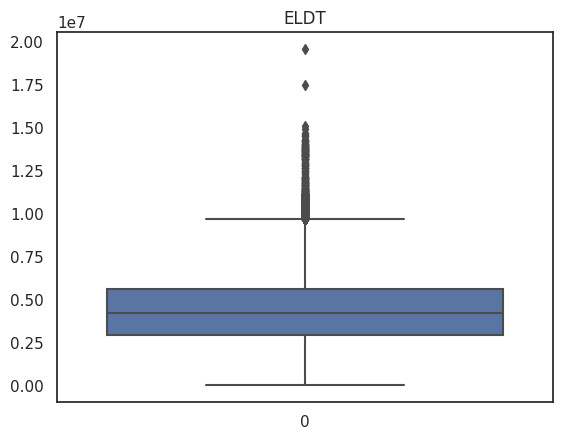

In [ ]:
# Boxplot do ELDT
# fig = px.box(BIMTRA_df_adjusted['eldt'], title='ELDT', labels={'value': 'ELDT'}, points='outliers')
# fig.update_traces(dict(marker=dict(size=7,color="darkslategrey"),line=dict(width=1, color="darkslategrey")))
# fig.show()
sns.boxplot(BIMTRA_df_adjusted['eldt'], showfliers=True)

plt.title('ELDT')

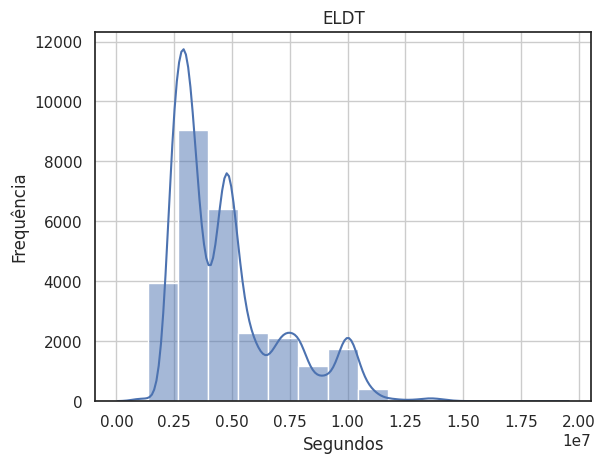

In [ ]:
sns.histplot(BIMTRA_df_adjusted['eldt'], bins=15, kde = True)

plt.xlabel('Segundos')
plt.ylabel('Frequência')
plt.title('ELDT')
plt.grid(True)

# Exiba o histograma
plt.show()

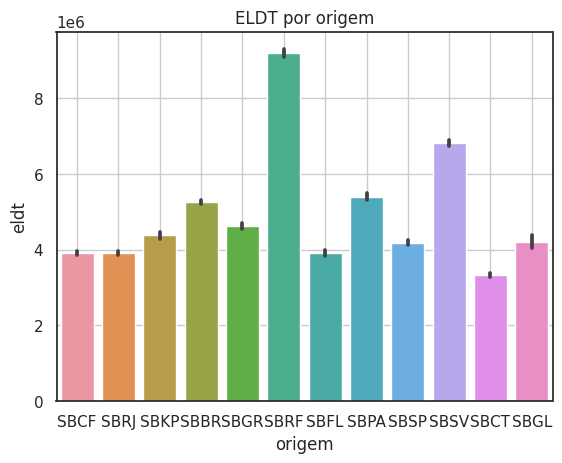

In [ ]:
sns.barplot(x=BIMTRA_df_adjusted['origem'], y=BIMTRA_df_adjusted['eldt'])

plt.title('ELDT por origem')
plt.grid(True)

plt.show()

In [ ]:
# Agrupar por origem e destino e calcular as estatísticas
impacto_aeroportos = BIMTRA_df_adjusted.groupby(['origem', 'destino']).agg({
    'flightid': 'count',              # Número total de voos
    'eldt': ['mean', 'min', 'max', 'std']  # Estatísticas de tempo de voo
}).reset_index()

# Renomear colunas para maior clareza
impacto_aeroportos.columns = ['Origem', 'Destino', 'Total_Voos', 'Tempo_Médio', 'Tempo_Mínimo', 'Tempo_Máximo', 'Desvio_Padrão']


display(impacto_aeroportos)

,Origem,Destino,Total_Voos,Tempo_Médio,Tempo_Mínimo,Tempo_Máximo,Desvio_Padrão
0,SBBR,SBCF,254,3.437173e+06,2340000,5351000,351330.201641
1,SBBR,SBCT,124,5.549984e+06,4999000,7148000,291940.744179
2,SBBR,SBFL,49,6.649143e+06,6020000,7864000,399364.234336
3,SBBR,SBGL,73,4.774932e+06,4400000,6307000,293942.848223
4,SBBR,SBGR,347,4.724467e+06,3434000,15094000,634457.085210
...,...,...,...,...,...,...,...
122,SBSV,SBKP,165,7.576867e+06,6811000,9608000,426673.913493
123,SBSV,SBPA,22,1.158959e+07,11010000,12466000,374015.489760
124,SBSV,SBRF,163,3.835374e+06,3360000,6515000,432963.803777
125,SBSV,SBRJ,206,6.778165e+06,5851000,10387000,543182.763064


# 3. Pré-processamento

In [ ]:
BIMTRA_df_adjusted

,flightid,origem,destino,dt_dep,dt_arr,eldt
0,33ce5d33ca3414163a9a53b8ef481306,SBCF,SBKP,1672532479000,1672535819000,3340000
1,af199802cfa3ca88b4ed914d5d6eeac8,SBRJ,SBSP,1672531827000,1672534699000,2872000
2,a3c9ce921ea79926bd098837cabc0cdd,SBKP,SBPA,1672537722000,1672542680000,4958000
3,8d03bca2ee2d1def11cd7e8c5e5aa0ae,SBBR,SBCF,1672536591000,1672540037000,3446000
4,95093c33bb1c2c612ff0b56c65d05dbe,SBKP,SBGL,1672539714000,1672541937000,2223000
...,...,...,...,...,...,...
27384,783af9769d54638a2e50437558879fd0,SBCF,SBGR,1675258279000,1675261109000,2830000
27385,9b392363bc952a42e0e036eaeaaa37ea,SBBR,SBGR,1675260249000,1675264712000,4463000
27386,f9fad7a3ace67914c4e2a5033edb5782,SBCT,SBGR,1675255923000,1675258787000,2864000
27387,8b55f0da1f2bac4a17e5d48bac7c052b,SBCF,SBGR,1675288765000,1675292684000,3919000


In [ ]:
BIMTRA_df_encoded = BIMTRA_df_adjusted.copy()

# # One hot encoding das chegadas

# origem = BIMTRA_df_adjusted['origem'].unique()
# origem = pd.get_dummies(origem, prefix='origem')
# BIMTRA_df_encoded = BIMTRA_df_adjusted.join(origem)

# # One hot encoding dos destinos

# destino = BIMTRA_df_encoded['destino'].unique()
# destino = pd.get_dummies(destino, prefix='destino')
# BIMTRA_df_encoded = BIMTRA_df_encoded.join(destino)
# BIMTRA_df_encoded

# BIMTRA_df_encoded.drop(['origem', 'destino'], axis=1, inplace=True)

# Organizando a ordem das colunas
l = list(BIMTRA_df_encoded.columns)
l.remove('eldt')
l.remove('flightid')
l.remove('dt_arr')
l.append('eldt')

BIMTRA_df_encoded = BIMTRA_df_encoded[l]

# Converte variáveis categoricas para o tipo "category" (Requisito pro XGBoost funcionar)
BIMTRA_df_encoded['origem'] = BIMTRA_df_encoded['origem'].astype('category')
BIMTRA_df_encoded['destino'] = BIMTRA_df_encoded['destino'].astype('category')
BIMTRA_df_encoded

,origem,destino,dt_dep,eldt
0,SBCF,SBKP,1672532479000,3340000
1,SBRJ,SBSP,1672531827000,2872000
2,SBKP,SBPA,1672537722000,4958000
3,SBBR,SBCF,1672536591000,3446000
4,SBKP,SBGL,1672539714000,2223000
...,...,...,...,...
27384,SBCF,SBGR,1675258279000,2830000
27385,SBBR,SBGR,1675260249000,4463000
27386,SBCT,SBGR,1675255923000,2864000
27387,SBCF,SBGR,1675288765000,3919000


# 4. Treinamento 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(BIMTRA_df_encoded.copy().drop('eldt', axis=1), BIMTRA_df_encoded['eldt'], test_size=0.2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27353 entries, 0 to 27388
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   origem   27353 non-null  category
 1   destino  27353 non-null  category
 2   dt_dep   27353 non-null  int64   
 3   eldt     27353 non-null  int64   
dtypes: category(2), int64(2)
memory usage: 1.7 MB


In [ ]:
reg = xg.XGBRegressor(enable_categorical=True)
reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## 4.1 Performance do modelo

In [ ]:
print("Performance do modelo nos dados de treino: ", str(round(reg.score(X_train, y_train) * 100, 2))+"%")
print("Performance do modelo nos dados de teste: ", str(round(reg.score(X_test, y_test) * 100, 2))+"%")

Performance do modelo nos dados de treino:  98.25%
Performance do modelo nos dados de teste:  96.67%


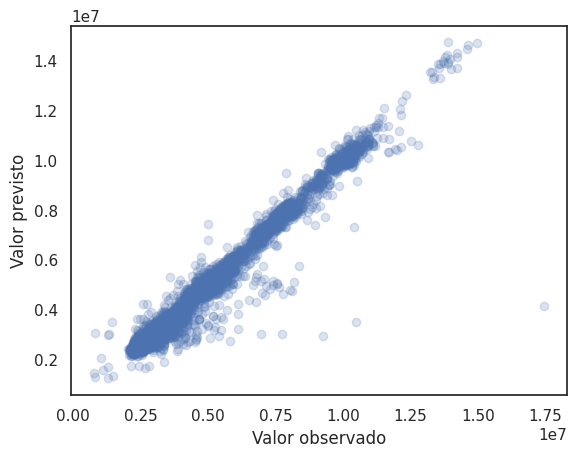

In [ ]:
# Previsão
y_pred = reg.predict(X_test)

plt.scatter(y_test, y_pred, alpha=0.2)
plt.xlabel('Valor observado')
plt.ylabel('Valor previsto')
plt.show()

# fig = px.scatter(x=y_test, y=y_pred)
# fig.update_xaxes(title="Valor observado")
# fig.update_yaxes(title="Valor previsto")

# # Add a title
# fig.update_layout(title="Valor observado vs. Valor previsto")


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("Erro Quadrático Médio (MSE): ", mean_squared_error(y_test, y_pred))
print("Erro Absoluto Médio (MAE): ", mean_absolute_error(y_test, y_pred))
print("Raiz do Erro Quadrático Médio (RMSE) : ", np.sqrt(mean_squared_error(y_test, y_pred)))

print("R2: ", r2_score(y_test, y_pred))

Erro Quadrático Médio (MSE):  184583996605.22125
Erro Absoluto Médio (MAE):  230239.818360446
Raiz do Erro Quadrático Médio (RMSE) :  429632.3970619782
R2:  0.9667304579099598


# 5. Submissão

In [ ]:
idsc_test = pd.read_csv('idsc_test.csv')
idsc_test

,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,...,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,2023-05-30 11:36:03.000,2023-05-30 11:00:00.000,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,...,NaN,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,SBSV,NaN,NaN
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,2023-05-19 08:26:06.000,2023-05-19 08:00:00.000,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,...,METAF SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,SBRJ,NaN,NaN
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,2023-05-22 11:52:02.000,2023-05-22 11:00:00.000,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,...,METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=,SBGR,2023-05-22 12:00:00.000,0,SBGR,NaN,NaN
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,2023-05-29 16:07:07.000,2023-05-29 16:00:00.000,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,...,METAF SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,SBSP,NaN,NaN
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,2023-05-25 22:16:04.000,2023-05-25 22:00:00.000,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,...,METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=,SBKP,2023-05-25 23:00:00.000,0,SBKP,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6f6d576aafbd90e308a848a060395e9a,SBPA,SBGR,2023-05-19 22:02:03.000,2023-05-19 22:00:00.000,MULTIPOINT ((-0.8891070333352145 -0.5128856751...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 21:00:00.000,0,SBGR,...,METAF SBGR 192300Z 11006KT 9000 FEW019 ...,SBGR,2023-05-19 22:00:00.000,METAR SBGR 192200Z 14003KT CAVOK 16/13 Q1021=,SBGR,2023-05-19 23:00:00.000,0,SBGR,NaN,NaN
96,20055ed6ecea5e916923081fc3b049f7,SBCF,SBKP,2023-05-31 19:54:04.000,2023-05-31 19:00:00.000,MULTIPOINT ((-0.8887839089364267 -0.5156303040...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-31 18:00:00.000,0,SBKP,...,METAF SBKP 312000Z 23006KT 9999 OVC022 ...,SBKP,2023-05-31 19:00:00.000,METAR SBKP 311900Z 24005KT 5000 2000S -RA BR B...,SBKP,2023-05-31 20:00:00.000,0,SBKP,2023-05-31 19:00:00.000,SBKP
97,c5e4e8d78906ae2b3218847cc9f045d9,SBSP,SBRJ,2023-05-20 15:16:05.000,2023-05-20 15:00:00.000,MULTIPOINT ((-0.8916331377478003 -0.5089690765...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-20 14:00:00.000,0,SBRJ,...,METAF SBRJ 201600Z 10003KT 9999 FEW033 ...,SBRJ,2023-05-20 15:00:00.000,METAR SBRJ 201500Z 34003KT 250V040 CAVOK 23/16...,SBRJ,2023-05-20 16:00:00.000,0,SBRJ,NaN,NaN
98,878ad3e9104c78f2945f6194c2d883ce,SBBR,SBSP,2023-05-31 11:31:02.000,2023-05-31 11:00:00.000,MULTIPOINT ((-0.8987280459174578 -0.5209708603...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-31 10:00:00.000,0,SBSP,...,METAF SBSP 311200Z 07006KT 6000 - RA OVC026 ...,SBSP,2023-05-31 11:00:00.000,METAR SBSP 311100Z 08006KT 020V120 4000 -RA BR...,SBSP,2023-05-31 12:00:00.000,0,SBSP,NaN,NaN


In [ ]:
idsc_test_encoded = idsc_test.copy()

# # One hot encoding das chegadas

# origem = idsc_test_encoded['origem'].unique()
# origem = pd.get_dummies(origem, prefix='origem')
# idsc_test_encoded = idsc_test_encoded.join(origem)

# # One hot encoding dos destinos

# destino = idsc_test_encoded['destino'].unique()
# destino = pd.get_dummies(destino, prefix='destino')
# idsc_test_encoded = idsc_test_encoded.join(destino)
# idsc_test_encoded

# idsc_test_encoded.drop(['origem', 'destino'], axis=1, inplace=True)

# Organizando a ordem das colunas
l = list(idsc_test_encoded.columns)
l.remove('flightid')

idsc_test_encoded = idsc_test_encoded[l]

filtro = pd.Series(idsc_test_encoded.columns)

filtro = filtro[filtro.isin(BIMTRA_df_encoded.columns)]

idsc_test_encoded = idsc_test_encoded[filtro]

idsc_test_encoded['dt_dep'] = pd.to_datetime(idsc_test_encoded['dt_dep'], format='%Y-%m-%d %H:%M:%S.%f')

idsc_test_encoded['dt_dep'] = (idsc_test_encoded['dt_dep'].astype(int) / 10**6)#.astype('datetime64[ms]')

# Converte variáveis categoricas para o tipo "category" (Requisito pro XGBoost funcionar)
idsc_test_encoded['origem'] = idsc_test_encoded['origem'].astype('category')
idsc_test_encoded['destino'] = idsc_test_encoded['destino'].astype('category')

idsc_test_encoded

,origem,destino,dt_dep
0,SBKP,SBSV,1.685447e+12
1,SBFL,SBRJ,1.684485e+12
2,SBCF,SBGR,1.684756e+12
3,SBFL,SBSP,1.685376e+12
4,SBCF,SBKP,1.685053e+12
...,...,...,...
95,SBPA,SBGR,1.684534e+12
96,SBCF,SBKP,1.685563e+12
97,SBSP,SBRJ,1.684596e+12
98,SBBR,SBSP,1.685533e+12


In [ ]:
y_pred = reg.predict(idsc_test_encoded)

data_in_seconds = y_pred / 1000.0

# Criar um DataFrame com a coluna de dados em segundos
y_pred = pd.DataFrame(data_in_seconds)

y_pred

,0
0,7183.612793
1,4142.768066
2,3552.894043
3,2917.811279
4,3267.568848
...,...
95,5290.012695
96,3267.568848
97,2611.478516
98,5115.635742


In [ ]:
sumbission = pd.DataFrame()

sumbission['ID'] = idsc_test['flightid']
sumbission['solution'] = y_pred


sumbission
sumbission.to_csv('submission.csv', index=False)

,ID,solution
0,7945735584a3297121c4f5ae0de8ecd1,4093.581543
1,85cb958e8b9d583575cd9cb93e389226,3873.401611
2,2d4e8cd3947525a12ff16af520beefb9,3873.401611
3,24cf317a1494a016a018d9f5cd183639,3890.303711
4,370babaf32dc82a6a64bf5b71a3434ed,3873.401611
...,...,...
95,6f6d576aafbd90e308a848a060395e9a,4093.581543
96,20055ed6ecea5e916923081fc3b049f7,4093.581543
97,c5e4e8d78906ae2b3218847cc9f045d9,4093.581543
98,878ad3e9104c78f2945f6194c2d883ce,4093.581543


In [ ]:
sumbission

,ID,solution
0,7945735584a3297121c4f5ae0de8ecd1,7183.612793
1,85cb958e8b9d583575cd9cb93e389226,4142.768066
2,2d4e8cd3947525a12ff16af520beefb9,3552.894043
3,24cf317a1494a016a018d9f5cd183639,2917.811279
4,370babaf32dc82a6a64bf5b71a3434ed,3267.568848
...,...,...
95,6f6d576aafbd90e308a848a060395e9a,5290.012695
96,20055ed6ecea5e916923081fc3b049f7,3267.568848
97,c5e4e8d78906ae2b3218847cc9f045d9,2611.478516
98,878ad3e9104c78f2945f6194c2d883ce,5115.635742


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4ef28bfa-f18c-417e-93b5-8e27cf9bc92e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>